In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from xclim.core.missing import missing_pct
from xclim.indices.generic import select_resample_op
from xclim.indices.stats import fa, fit, frequency_analysis, parametric_quantile
import gdown

In [2]:
#'GOOGLE_DRIVE_LINK' to NetCDF file
url = 'https://drive.google.com/file/d/1ljDfwAeyfLNMsArQDOFP9-7y4EC7Brxq/view?usp=drive_link'
# Download the NetCDF file
file_path = 'data/input/ERA5_Tenerife_total_precipitation_day_1950_2000.nc'
gdown.download(url, file_path, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1ljDfwAeyfLNMsArQDOFP9-7y4EC7Brxq
To: /home/mlanger/Dokumente/Lehre/Earth science observation research methods/scripts/notebooks/data/input/ERA5_Tenerife_total_precipitation_day_1950_2000.nc
100%|██████████████████████████████████████| 6.06M/6.06M [00:01<00:00, 5.00MB/s]


'data/input/ERA5_Tenerife_total_precipitation_day_1950_2000.nc'

In [3]:
# Load the ERA5 reanalysis daily precipitation data for Tenerife from 1950 - 2000 
file_path = 'data/input/ERA5_Tenerife_total_precipitation_day_1950_2000.nc'

daily_precipitation = xr.open_dataset(file_path)
# Add an attribute to the dataset
daily_precipitation.attrs['units'] = 'mm/d'
# create a array which only conains the years 
years = daily_precipitation['time'].dt.year.values

In [4]:
# Print the loaded data base
daily_precipitation

<xarray.Dataset>
Dimensions:    (time: 18679, bnds: 2, longitude: 5, latitude: 5)
Coordinates:
  * time       (time) datetime64[ns] 1949-12-31T23:00:00 ... 2000-12-31T11:00:00
  * longitude  (longitude) float32 -17.0 -16.75 -16.5 -16.25 -16.0
  * latitude   (latitude) float32 28.75 28.5 28.25 28.0 27.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    tp         (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Mon Jan 08 10:54:24 2024: cdo -b F64 -daysum -shifttime,-1s...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...
    units:        mm/d

In [5]:
# Calcualte mean total annual precipitation

# first group by year and sum up values
annual_total_precipitation = daily_precipitation.groupby('time.year').sum(dim='time')
# second calaculate the mean
annual_total_precipitation_mean = annual_total_precipitation.mean(dim='year')
annual_total_precipitation_mean

<xarray.Dataset>
Dimensions:    (longitude: 5, latitude: 5)
Coordinates:
  * longitude  (longitude) float32 -17.0 -16.75 -16.5 -16.25 -16.0
  * latitude   (latitude) float32 28.75 28.5 28.25 28.0 27.75
Data variables:
    tp         (latitude, longitude) float64 218.9 249.0 240.7 ... 126.6 120.8

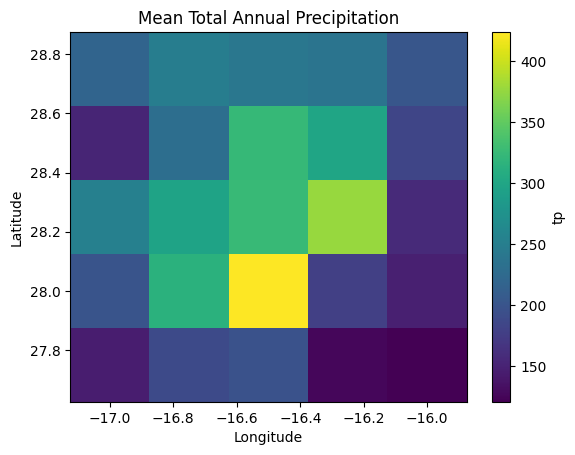

In [6]:
# Plot the map of mean total annual precipitation
annual_total_precipitation_mean['tp'].plot.imshow()
plt.title('Mean Total Annual Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [7]:
threshold = 30

#Calaculate the mean annual intensity of precipitation events > threshold
intensity_threshold = daily_precipitation.where(daily_precipitation['tp'] > threshold)
intensity_annual_sum = intensity_threshold.groupby('time.year').sum(dim='time')
intensity_mean = intensity_annual_sum.mean(dim='year')

#Calaculate the mean annual probability of precipitation events > threshold
probability_n = (daily_precipitation['tp'] > threshold)
probability_n_annual_sum = probability_n.groupby('time.year').sum(dim='time')
probability_annual_mean = probability_n_annual_sum / 365 
probability_mean = probability_annual_mean.mean(dim='year')

#probability_mean_xr = xr.Dataset({'intensity':probability_mean.values}, coords={'longitude': probability_mean['longitude'],'latitude': probability_mean['latitude']})
probability_mean_xr = xr.Dataset({'probability':probability_mean})

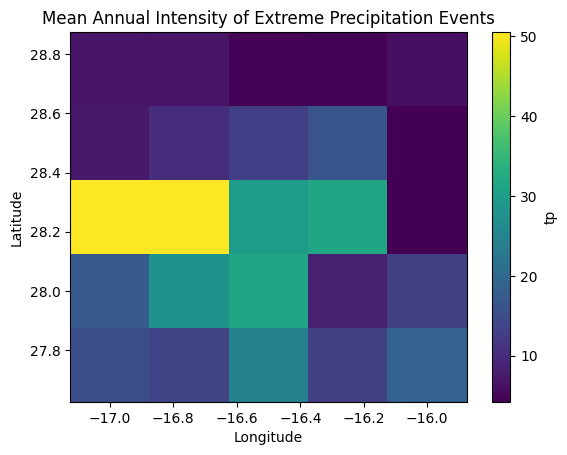

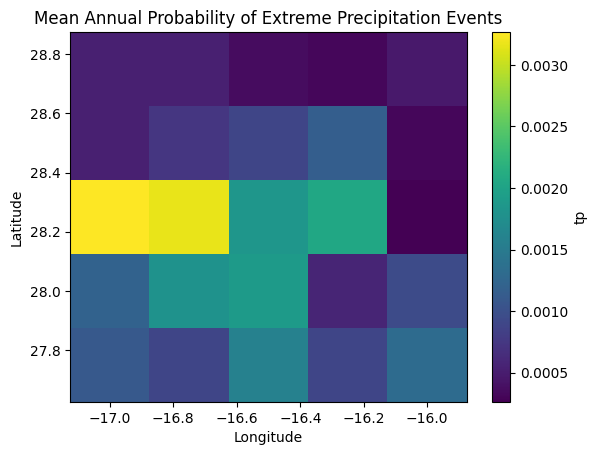

In [8]:
# Plot mean annual intensity map of precipitation events > threshold
intensity_mean['tp'].plot.imshow()
plt.title('Mean Annual Intensity of Extreme Precipitation Events')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plot mean annual probability precipitation events > threshold
probability_mean.plot.imshow()
plt.title('Mean Annual Probability of Extreme Precipitation Events')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [9]:
# Store the mean and median maps as netcdf file in the given folder
path = 'data/results/'
filename = 'ERA5_Tenerife_mean_total_precipitation_'  + str(years[0]) + '_' + str(years[-1]) + '.nc'
annual_total_precipitation_mean.to_netcdf(path + filename)

filename = 'ERA5_Tenerife_intensity_extreme_precipitation_' + str(threshold) + 'mm_'  + str(years[0]) + '_' + str(years[-1]) + '.nc'
intensity_mean.to_netcdf(path + filename)

filename = 'ERA5_Tenerife_probability_extreme_precipitation_' + str(threshold) + 'mm_' + str(years[0]) + '_' + str(years[-1]) + '.nc'
probability_mean_xr.to_netcdf(path + filename)

Now perform the following analysis:
- Calaculate the block maxima with annual frequency for each pixel
- Fit the GEV function to these maxima for each pixel
- Calculate the expected extreme precipitation events for 5, 10 and 20 year return periods
- Create complete maps of the expected extreme precipitation events with QGIS (use the Tenerife Shapefile)

Make use of the [xclim libary](https://xclim.readthedocs.io/en/stable/notebooks/frequency_analysis.html) which is already imported (see script header)

In [10]:
# Technical thing - we have to make sure that all variables have the data type (e.g. float)
daily_precipitation = daily_precipitation.astype(float)


# We use the libary xclim (https://xclim.readthedocs.io/en/stable/notebooks/frequency_analysis.html)
# in order to optain the Block Maxima with yearly frequency
sub = select_resample_op(daily_precipitation, op="max", freq="YS")



In [11]:
# We use the xclim libary to fit GEV function
params = fit(sub, dist="genextreme")

In [12]:
# We use the xclim libary to extract the quantile value for a given return period 
return_period = 20
pq = parametric_quantile(params, q = 1 - 1.0 / return_period)
pq

<xarray.Dataset>
Dimensions:    (bnds: 2, quantile: 1, latitude: 5, longitude: 5)
Coordinates:
  * longitude  (longitude) float32 -17.0 -16.75 -16.5 -16.25 -16.0
  * latitude   (latitude) float32 28.75 28.5 28.25 28.0 27.75
  * quantile   (quantile) float64 0.95
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (bnds, quantile) float64 8.691e+17 8.691e+17
    tp         (quantile, latitude, longitude) float64 38.51 35.36 ... 51.25
Attributes:
    CDI:           Climate Data Interface version 1.9.9rc1 (https://mpimet.mp...
    Conventions:   CF-1.6
    history:       Mon Jan 08 10:54:24 2024: cdo -b F64 -daysum -shifttime,-1...
    frequency:     day
    CDO:           Climate Data Operators version 1.9.9rc1 (https://mpimet.mp...
    units:         mm/d
    long_name:     genextreme quantiles
    description:   Quantiles estimated by the genextreme distribution
    method:        ML
    estimator:     Maximum likelihood
    scipy_dist:    genextreme
    cell_methods:  dparams: ppf

In [13]:
# Befor saving as 2D map get rid of the quatile dimension
pq = pq.sel(quantile=pq['quantile'][0], drop=True)

# Save map as new netcdf file
filename = 'ERA5_Tenerife_precipitation_event_return_period_'  + f'T_ {return_period:.0f}' + '.nc'
pq.to_netcdf(path + filename)